Monte Carlo theory: Reference book:https://statweb.stanford.edu/~owen/mc/ <br>
Reference: Machine Learning, a Probabilistic Perspective, by Kevin P. Murphy

------
## Sampling methods
1. Importance Sampling
2. Sequential Importance Sampling (SIS)
3. Sampling Importance Resampling (SIR)
4. Sequential Importance Sampling and Resampling (particle filter)

------

# Importance Sampling

Our target is to find $\mu$, where $\mu = E[f(x)] = \int_D f(x)p(x) dx$. Simple Monte Carlo method suggests:
\begin{equation}
\mu \approx \frac{1}{N} \sum_{i=1}^N f(x^i)  \qquad x^i \sim p(x)
\end{equation}
However, simple Monte Carlo method may fail when f(x) are nearly zero outside region A and $P(x\in A)$ is small. Intuitively we would like to have more samples from the important region A.

Therefore, we use Importance Sampling:
$$
\begin{align}
\mu & = \int_D f(x) \frac{p(x)}{q(x)}q(x) \quad dx = E_q\Big[f(X)\frac{p(X)}{q(X)} \Big] \\
& \approx \frac{1}{N} \sum_{i=1}^N f(X_i)\frac{p(X_i)}{q(X_i)} \quad X_i \sim q
\end{align}
$$
Assume we can compute f(x), to use the above equation, we have to be able to compute $p(x)/q(x)$. Details about the estimate variance and how to choose $q(x)$ were discussed in details in the reference book.

## self-normalized importance sampling
Sometimes we can only have unnormalized p(x) and q(x), therefore we use:

\begin{equation}
\hat\mu_q = \frac{\sum_{i=1}^N f(X_i)w(X_i)}{\sum_{i=1}^N w(X_i)} \quad X_i \sim q
\end{equation}

------
### A short example of Importance Sampling:
Say we want have a chopped cosine function:

\begin{equation}
p(x) = \frac{1}{Z}\cos x \quad x\in[0,1]
\end{equation}

Now we would like to know the average of this distribution $E[x]=\int_0^1 xp(x)$. It's hard to sample from $p(x)$, so we sample from $q(x)=Uni(1) \quad x\in[0,1]$. Therefore, the self-normalized importance sampling give:

\begin{equation}
E[x] \approx \frac{\sum_{i=1}^N x^i w^i}{\sum_{i=1}^N w^i} = \frac{\sum_{i=1}^N x^i \cos x^i}{\sum_{i=1}^N \cos x^i} \quad x^i \sim q(x)
\end{equation}

In [3]:
##### A short example of Importance Sampling
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
x = np.random.rand(1000)
Ex = np.sum(x*np.cos(x))/np.sum(np.cos(x))
print('Importance sampling give estimates: ',Ex)
print('Exact solution calculated by direct integration:',(np.sin(1) + np.cos(1)-np.cos(0))/np.sin(1))

Importance sampling give estimates:  0.4475830626547495
Exact solution calculated by direct integration: 0.4536975101562095


------
# Sequential Importance Sampling (SIS)
Motivation: Sequential Importance Sampling was designed for state-space model. State variables: $x_{t}$, Measurements: $z_t$.

Consider a general state-space model: We want to approximate: (If you find this expression hard to understand, look at the SIR section first.)
$$
\begin{equation}
p(x_{1:t}|z_{1:t}) \approx \sum_{s=1}^S \hat{w}_t^s \delta_{x_{1:t}^s}
\end{equation}
$$
The weights could be expressed as follow given assupmtions of state-space model:
$$
\begin{equation}
w_t^s \propto \frac{p(x_{1:t}^s | z_{1:t})}{q(x_{1:t}^s | z_{1:t})} = w_{t-1}^s \frac{p(z_t | x_t)p(x_t | x_{t-1})}{q(x_t | x_{1:t-1},z_{1:t})}
= w_{t-1}^s \frac{p(z_t | x_t)p(x_t | x_{t-1})}{q(x_t | x_{t-1})}
\end{equation}
$$

State/particles update equations are:
$$
\begin{align}
x_t^s &\sim q(x_t | x_{1:t-1},z_{1:t}) \\
w_t^s &\propto w_{t-1}^s \frac{p(z_t | x_t)p(x_t | x_{t-1})}{q(x_t | x_{1:t-1},z_{1:t})}
\end{align}
$$

However, degeneracy problem may occur after a few updates, where very few weights will dominate and all the rest are around 0. This is not desired. Degeneracy problem can be quantify using the effective sample size:
$$
\begin{equation}
\hat{S}_{eff} = \frac{1}{\sum_{s=1}^S (w_t^s)^2}
\end{equation}
$$

### Example: Linear Gaussian Model

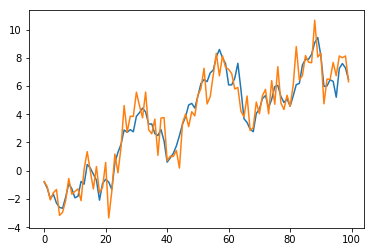

In [83]:
# Linear Gaussian Model
random_seed = 123456789
v = np.random.normal(0,0.8,100)
w = np.random.normal(0,1,100)
A, C = 1.1, 1
x = v
x = np.cumsum(A*x)
z = C*x + w
plt.plot(x)
plt.plot(z)


In [77]:
from scipy import stats
time = 20
particle_number = 50
particles_Log = np.zeros([particle_number,time])
weights_Log = np.zeros([particle_number,time])
# initialize
particles = np.random.normal(0,1,particle_number)
weights = np.ones(particle_number)/particle_number
#particles_Log[:,0] = particles
#weights_Log[:,0] = weights
for i in range(time):
    particles = np.random.normal(A*particles,[0.8]*particle_number,particle_number)
    weights = weights*stats.norm(C*particles,[1]*particle_number).pdf(z[i])
    weights = weights/sum(weights)
    particles_Log[:,i] = particles
    weights_Log[:,i] = weights


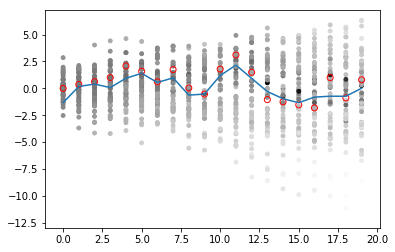

In [78]:
import warnings
warnings.filterwarnings('ignore')

colorScale = np.log(np.log(1/(weights_Log)))
plt.scatter([range(time)]*particle_number, particles_Log, c=colorScale,cmap='gray',s=15)
plt.plot(x[:time])
plt.scatter(range(time),z[:time],facecolors='none', edgecolors='r')
#plt.xlim([-0.5,time+0.5])



------
# Sampling Importance Resampling (SIR)
Motivation: Resampling was designed to counter the degeneracy problem of SIS. 

Alternative interpretation: For ordinary Importance Sampling algo., we have a target distribution p(x) (say a normal distribution) and a proposal distribution q(x) (say a uniform distribution). We sample from q(x) which is uniformly distributed. If we want samples normally distributed, we need to resample them according to their weights. The new samples have equal weights because we sample them with replacement.

We can use importance sampling to approximate target distribution:
$$
\begin{equation}
p(x) \approx \sum_{s=1}^S  w^s \delta_{x^s}
\end{equation}
$$
where $\delta_{x^s}$ are particles sampled from q(x). If you find this equation hard to understand, think back to the simple Normal/Uniform example. You can roughly know the distribution when you have enough sample spikes.<br>
Then We resample/reselect the particles with chance of their weights. Then we will have an unweighted approximation:
$$
\begin{equation}
p(x) \approx \frac{1}{S'}\sum_{s=1}^{S'}\delta_{x^s}
\end{equation}
$$
Think this as superimposing delta function/particles. From the expression, we can also see the resampled samples all have equal weights.

------
# Sequential Importance Sampling with Resampling (Particle Filter)

##### Algorithm: One step of a particle filter
- for s = 1:S do:
    - Draw $ Z_t^s \sim q(z_t | z_{t-1}^s, y_t)$
    - Compute weight $ w_t^S \propto w_{t-1}^s \frac{p(y_t | z_t^s) p(z_t^s | z_{t-a}^s)}{q(z_t^s | z_{t-1}^s, y_t)} $
- end do
- Normalize weights: $ w_t^s = \frac{w_t^s}{\sum_{s} w_t^s} $
- Compute $ S_{eff}=\frac{1}{\sum_s (w_t^s)^2} $
- If $S_{eff}<S_{th}$:
    - Resample S indices $\pi \sim w_t$
    - $z_t^: = z_t^{\pi}$
    - $w_t^s = \frac{1}{S}$
 
### Example: Linear Gaussian Model:


In [84]:
from scipy import stats
time = 100
particle_number = 50
particles_Log = np.zeros([particle_number,time])
weights_Log = np.zeros([particle_number,time])
# initialize
particles = np.random.normal(0,1,particle_number)
weights = np.ones(particle_number)/particle_number
#particles_Log[:,0] = particles
#weights_Log[:,0] = weights
for i in range(time):
    particles = np.random.normal(A*particles,[0.8]*particle_number,particle_number)
    weights = weights*stats.norm(C*particles,[1]*particle_number).pdf(z[i])
    weights = weights/sum(weights)    
    particles_Log[:,i] = particles
    weights_Log[:,i] = weights
    # resample
    occurance = np.random.multinomial(particle_number,weights)
    r = []
    for i in range(particle_number):
        r +=[particles[i]]*occurance[i]
    particles = np.array(r)
    weights = 1/particle_number

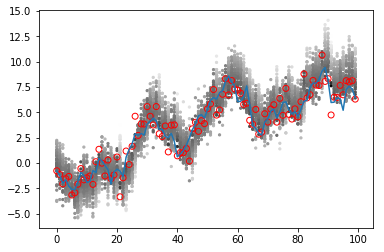

In [85]:

colorScale = np.log(np.log(1/(weights_Log)))
plt.scatter([range(time)]*particle_number, particles_Log, c=colorScale,cmap='gray',s=5)
plt.plot(x[:time])
plt.scatter(range(time),z[:time],facecolors='none', edgecolors='r')

 ------
# Eample: stochastic volatility model

# r=[]
power = [0,2,3,2,1]
for i in range(5):
    r += [np.arange(5)[i]] *power[i]

r